In [1]:
# Import libraries
import matplotlib.pyplot as plt # Matplotlib is used for plotting
import pandas as pd             # Pandas helps organize data structures
import numpy as np              # Numpy provides mathematical functions like sqrt()
import statsmodels.formula.api as sm  # Statsmodel provides linear regression
from sklearn import metrics 
from sklearn.model_selection import KFold
import skimage.io as io # Loads and displays images
import skimage as ski 
from scipy.linalg import svd
from pycocotools.coco import COCO # Coco dataset
from sklearn.decomposition import PCA


1. Load image URLS


In [2]:
#Initialize data file annotations
dataDir=''
dataType='val2017'
annFile='./annotations/instances_{}.json'.format(dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

paras = ['broccoli', 'apple', 'orange', 'carrot']
catIds = coco.getCatIds(paras);


loading annotations into memory...
Done (t=0.57s)
creating index...
index created!


In [3]:

# display COCO categories
cats = coco.loadCats(catIds)
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))
print('COCO category IDs:', catIds)

COCO categories: 
apple orange broccoli carrot

COCO category IDs: [53, 55, 56, 57]


In [4]:
#Concatenate all pictures within the categories
imgIds = []
for cat in cats:
    imgIds = imgIds + coco.getImgIds(catIds = cat['id'])
    
#2017 Val only 313 photos
print(len(imgIds))

313


In [5]:
# load and display image
# use url to load image (potentially change to local to improve performance for training)
# image = io.imread(img['coco_url'])

# use local image for loading (much faster)
# image = io.imread('./images/' + img['file_name'])

nsamples = len(imgIds)
nx = 480
ny = 640
ncolors = 3


imgU = np.ndarray(shape=(nsamples, nx * ny * ncolors))
index = 0

for imgId in imgIds:
    
    #Load image from local 
    img = coco.loadImgs(imgId)[0]
    image = io.imread('./images/' + img['file_name'])
    
    #display image
    #plt.axis('off')
    #plt.imshow(image)
    #plt.show()

    #resize image to 480x640
    image_resized = ski.transform.resize(image, (480,640),
                       anti_aliasing=True)
    
    
    #store image as a matrix of RGB floats
    imgMatrix = ski.img_as_float(image_resized)

    #convert matrix into single dimension
    imgMatrix = imgMatrix.reshape(1, nx * ny * ncolors)
    
    #add to our ndarray
    imgU[index] = imgMatrix
    index += 1
    print(str(index) + '/' + str(nsamples), end = '\r')
    




1 / 313
2 / 313
3 / 313
4 / 313
5 / 313
6 / 313
7 / 313
8 / 313
9 / 313
10 / 313
11 / 313
12 / 313
13 / 313
14 / 313
15 / 313
16 / 313
17 / 313
18 / 313
19 / 313
20 / 313
21 / 313
22 / 313
23 / 313
24 / 313
25 / 313
26 / 313
27 / 313
28 / 313
29 / 313
30 / 313
31 / 313
32 / 313
33 / 313
34 / 313
35 / 313
36 / 313
37 / 313
38 / 313
39 / 313
40 / 313
41 / 313
42 / 313
43 / 313
44 / 313
45 / 313
46 / 313
47 / 313
48 / 313
49 / 313
50 / 313
51 / 313
52 / 313
53 / 313
54 / 313
55 / 313
56 / 313
57 / 313
58 / 313
59 / 313
60 / 313
61 / 313
62 / 313
63 / 313
64 / 313
65 / 313
66 / 313
67 / 313
68 / 313
69 / 313
70 / 313
71 / 313
72 / 313
73 / 313
74 / 313
75 / 313
76 / 313
77 / 313
78 / 313
79 / 313
80 / 313
81 / 313
82 / 313
83 / 313
84 / 313
85 / 313
86 / 313
87 / 313
88 / 313
89 / 313
90 / 313
91 / 313
92 / 313
93 / 313
94 / 313
95 / 313
96 / 313
97 / 313
98 / 313
99 / 313
100 / 313
101 / 313
102 / 313
103 / 313
104 / 313
105 / 313
106 / 313
107 / 313
108 / 313
109 / 313
110 / 313
111 / 31

2. (For Efficiency) Do PCA on all images to reduce # of parameters


In [7]:
print(imgU.shape)
#don't use too many components or risk blue screening
pca = PCA(n_components = 20)

US = pca.fit_transform(imgU)
Vt = pca.components_

print(US.shape, Vt.shape)


(313, 921600)
(313, 20) (20, 921600)


(921600,)
(313, 921600)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(480, 640, 3)
[[[ 0.43262721  0.36309654  0.37951955]
  [ 0.43264488  0.36712333  0.3840651 ]
  [ 0.42019611  0.36116885  0.37457928]
  ...
  [ 0.09456992  0.00980142 -0.00917702]
  [ 0.0841997   0.00112973 -0.00983489]
  [ 0.08286096  0.00219254 -0.00683556]]

 [[ 0.42802708  0.35510992  0.36994802]
  [ 0.44591067  0.37995439  0.39723184]
  [ 0.39480229  0.32748995  0.34571207]
  ...
  [ 0.07779962 -0.01611315 -0.02727545]
  [ 0.10744288  0.0144292   0.00359221]
  [ 0.09037621  0.00147899 -0.01060981]]

 [[ 0.41969653  0.35202372  0.36428795]
  [ 0.44179686  0.37675049  0.39778524]
  [ 0.37195487  0.29267573  0.31408929]
  ...
  [ 0.07576329 -0.03268061 -0.03749458]
  [ 0.13704486  0.03192312  0.02805973]
  [ 0.11201092  0.0066968   0.00392864]]

 ...

 [[ 0.38733431  0.30469138  0.34280045]
  [ 0.3991132   0.33044745  0.36388486]
  [ 0.38314675  0.2991468   0.34054096]
  ...
  [ 0.26344933  0.19242769  0.18703197]
  [ 0.30567466  0.24317383  0.24482728]
  [ 0.28295166  0.2331831   0.

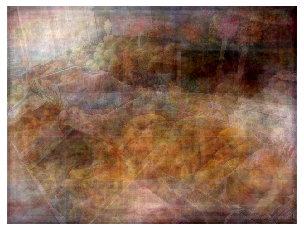

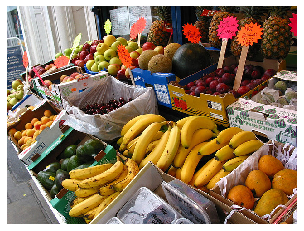

In [42]:


#reconstruct from PCA
X_hat = US @ Vt + pca.mean_

print(X_hat[0].shape)
print(X_hat.shape)

imgNew = np.ndarray(shape=(nx, ny, ncolors))

ix = 0
iy = 0
ic = 0
for i in X_hat[0]:
    imgNew[ix][iy][ic] = i
    ic += 1
    if ic >= ncolors:
        ic = 0
        iy += 1
    
    if iy >= ny:
        iy = 0
        ix += 1
        
print(imgNew.shape)
print(imgNew)

image = imgNew
    
plt.axis('off')
plt.imshow(image)
plt.show()

img = coco.loadImgs(imgIds[0])[0]
image = io.imread('./images/' + img['file_name'])
plt.axis('off')
plt.imshow(image)
plt.show()

3. Use K-Fold model selection with k=5 to pick best model

4. Try on some photos of our own